In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import contextily as cx
import warnings
import zipfile
import os
warnings.filterwarnings("ignore")

data_path = '../../data/'

In [15]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'/training_data/')
    with zipfile.ZipFile(data_path+'/GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'/training_data/')

In [16]:
columns = [
    'gbifID',
    'eventDate',
    'countryCode',
    'stateProvince',
    'decimalLatitude',
    'decimalLongitude',
    'species',
    'verbatimScientificName'
]

country_names = {'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa'}

data = (
    pd.read_csv('./training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
    [columns]
    [lambda x: (~x.decimalLatitude.isna()) & (~x.decimalLongitude.isna())]
    [lambda x: (x.decimalLatitude != 0.0) & (x.decimalLongitude != 0.0)]
    .assign(
        country =  lambda x: x.countryCode.map(country_names),
        species =  lambda x: x.verbatimScientificName.str.title()
    )
    .drop(['verbatimScientificName', 'countryCode'], 1)
)

np.sum(data.isna())/len(data)*100

gbifID              0.000000
eventDate           5.423446
stateProvince       0.308550
decimalLatitude     0.000000
decimalLongitude    0.000000
species             0.000000
country             0.000000
dtype: float64

# Spatial Distribution

In [17]:
def plot_species(fig, ax, frog_data, region_name):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color']
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    return
    
    
def plot_barchart(bar_data, ax):
    barchart = ax.bar(bar_data.index, bar_data)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index, rotation=45)
    ax.legend()

Text(0.5, 1.0, 'Frog occurrences by country')

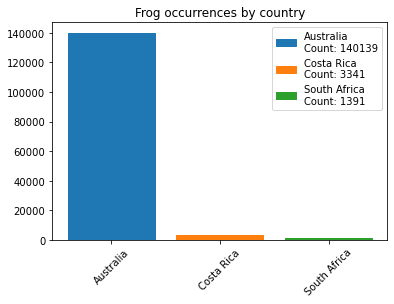

In [18]:
country_bar_data = data.country.value_counts()
fig, ax = plt.subplots()
plot_barchart(country_bar_data, ax)
ax.set_title('Frog occurrences by country')

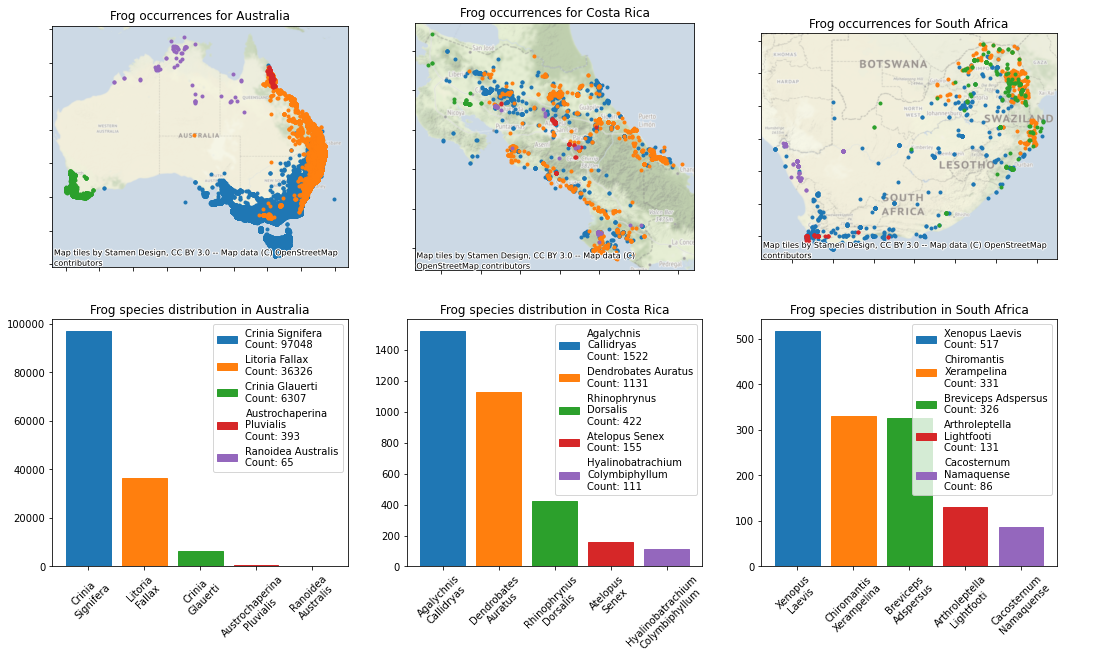

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

for i, cnt in enumerate(data.country.unique()):
    filt = data.country == cnt
    plot_species(fig, ax[:, i], data[filt], cnt)
    
plt.show()

## Temporal Distribution

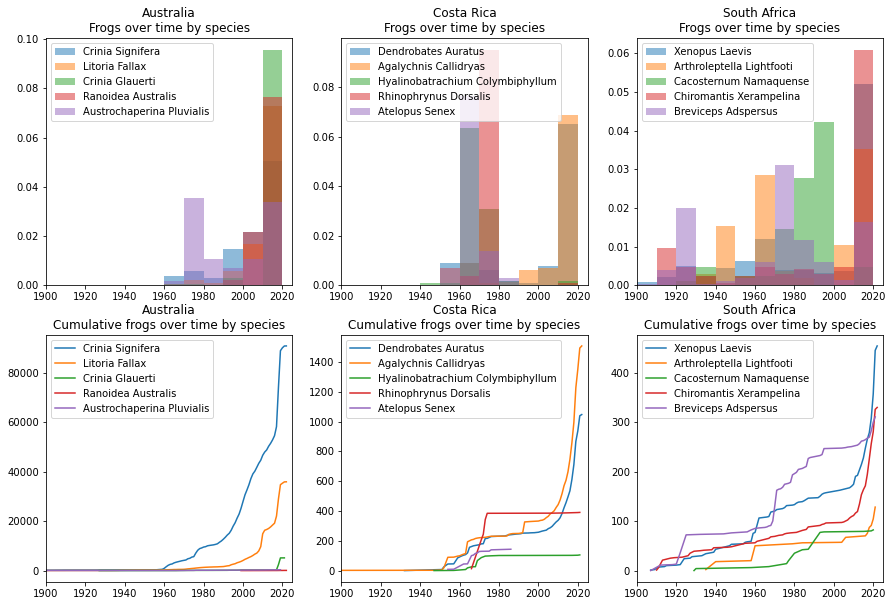

In [90]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, cnt in enumerate(data.country.unique()):
    country_data = data[data.country == cnt]    
    for species in country_data.species.unique():
        plot_data = country_data[lambda x: x.species == species]
        line_data = (
            plot_data
            [['eventDate']]
            .dropna()
            .assign(
                year = lambda x: x.eventDate.dt.year,
                n = 1
            )
            .groupby('year')
            .sum()
            .reset_index()
            .sort_values('year')
            .assign(ncum=lambda x: x.n.cumsum())
        )
        ax[1, i].plot(line_data.year, line_data.ncum, label=species)
        ax[0, i].hist(plot_data.eventDate.dt.year, alpha=0.5, label=species, density=True, bins=list(range(1900, 2025, 10)))
    xlim = (1900, 2025)
    # xlim = (country_data.eventDate.dt.year.min(), country_data.eventDate.dt.year.max()) 
    ax[1, i].legend(loc='upper left')
    ax[1, i].set_xlim(xlim)
    ax[1, i].set_title(f"{cnt}\nCumulative frogs over time by species")
    ax[0, i].legend(loc='upper left')
    ax[0, i].set_xlim(xlim)
    ax[0, i].set_title(f"{cnt}\nFrogs over time by species")


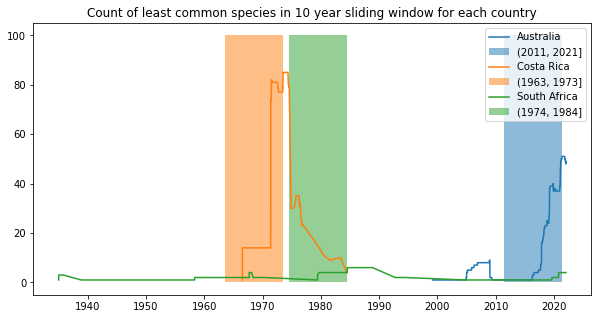

In [156]:
fig, ax = plt.subplots( figsize=(10, 5))

window_size = 10 # years

for i, cnt in enumerate(data.country.unique()):
    country_data = data[data.country == cnt]        
    coverage_plot = (
        pd.get_dummies(
            country_data
            [lambda x: ~x.eventDate.isna()]
            .set_index('eventDate').sort_index()
            [['species']]
        )
        .rolling(f'{365*window_size}D').sum()
        [lambda x: (x != 0)].dropna()
        .assign(
            min_freq = lambda x: np.min(x, axis=1)
        )
        .reset_index()
    )
    optimal = coverage_plot.eventDate[coverage_plot.min_freq.argmax()]
    ax.plot(coverage_plot.eventDate, coverage_plot.min_freq, label=f'{cnt}')
    ax.fill_between([optimal,optimal-pd.Timedelta(f'{window_size}Y')], 0, 100, alpha=0.5, label=f'({(optimal-pd.Timedelta(f"{window_size}Y")).year}, {optimal.year}]')
    
ax.legend()
ax.set_title(f'Count of least common species in {window_size} year sliding window for each country')
plt.show()
    

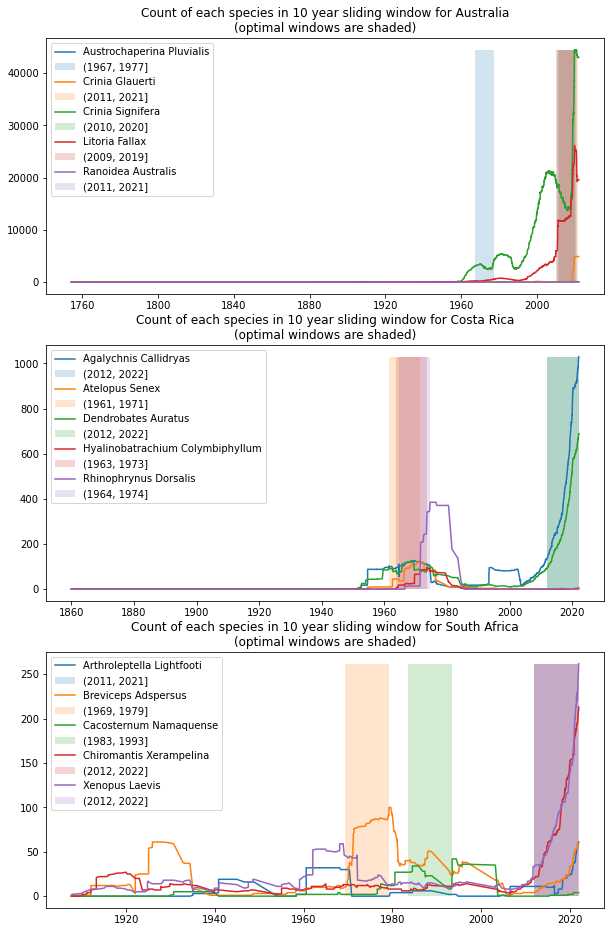

In [196]:
fig, ax = plt.subplots(3, 1, figsize=(10, 16))

window_size = 10 # years

for i, cnt in enumerate(data.country.unique()):
    country_data = data[data.country == cnt]  
    coverage_plot = (
        pd.get_dummies(
            (
                country_data
                [lambda x: ~x.eventDate.isna()]
                .set_index('eventDate').sort_index()
                [['species']]
            ),
            prefix='', prefix_sep=''
        )
        .rolling(f'{365*window_size}D').sum()
        .reset_index()
    )
    for j in range(1, len(coverage_plot.columns)):
        species = coverage_plot.columns[j]
        optimal = coverage_plot.eventDate[coverage_plot.iloc[:, j].argmax()]
        ax[i].plot(coverage_plot.eventDate, coverage_plot.iloc[:, j], label=f'{species}')
        ax[i].fill_between([optimal,optimal-pd.Timedelta(f'{window_size}Y')], 0, coverage_plot.iloc[:, 1::].max().max(), alpha=0.2, label=f'({(optimal-pd.Timedelta(f"{window_size}Y")).year}, {optimal.year}]')
    
    ax[i].legend()
    ax[i].set_title(f'Count of each species in {window_size} year sliding window for {cnt}\n(optimal windows are shaded)')
# plt.show()